In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.utils import resample
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
import plotly.figure_factory as ff
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.metrics import plot_roc_curve
from sklearn import metrics
from sklearn.metrics import roc_auc_score

In [2]:
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [3]:
df = pd.read_csv('petruta.csv')
df.rename(columns = {'ceva':'target'}, inplace = True)

In [4]:
df

,tx_id,sender_account_id,receiver_account_id,tx_type,tx_amount,timestamp,is_fraud,alert_id,f_time_true,sender_contaminat_f,receiver_contaminat_mtrx,target,cumulative_sar,init_balance,tx_behaviour_id
0,3537,9719,9260,TRANSFER,161.86,0,False,-1,-1,0,0,0,0,161.86,4
1,1263065,2489,4608,TRANSFER,13.52,191,True,215,191,1,1,1,1,503.56,3
2,1244665,2664,4035,TRANSFER,18.61,188,True,251,171,1,1,1,2,127.28,4
3,1143933,4944,9694,TRANSFER,3.46,173,True,156,173,1,0,1,1,328.17,5
4,1185514,7275,9694,TRANSFER,3.43,179,True,156,119,1,1,1,2,260.05,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1323229,441229,9999,8891,TRANSFER,317.64,67,False,-1,1,1,0,0,3,317.65,5
1323230,784178,9999,8095,TRANSFER,317.64,119,False,-1,1,1,0,0,4,317.65,5
1323231,784169,9999,8532,TRANSFER,317.64,119,False,-1,1,1,1,0,4,317.65,5
1323232,1041737,9999,9866,TRANSFER,317.64,157,False,-1,1,1,0,0,4,317.65,5


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1323234 entries, 0 to 1323233
Data columns (total 15 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   tx_id                     1323234 non-null  int64  
 1   sender_account_id         1323234 non-null  int64  
 2   receiver_account_id       1323234 non-null  int64  
 3   tx_type                   1323234 non-null  object 
 4   tx_amount                 1323234 non-null  float64
 5   timestamp                 1323234 non-null  int64  
 6   is_fraud                  1323234 non-null  bool   
 7   alert_id                  1323234 non-null  int64  
 8   f_time_true               1323234 non-null  int64  
 9   sender_contaminat_f       1323234 non-null  int64  
 10  receiver_contaminat_mtrx  1323234 non-null  int64  
 11  target                    1323234 non-null  int64  
 12  cumulative_sar            1323234 non-null  int64  
 13  init_balance              1

Variabile calculate de mine pe baza informatiilor disponibile:

sender_contaminat_f- momentul de la care sender-ul a devenit contaminat

receiver_contaminat_mtrx - o variabila binara care arata daca recevierul era contaminat la momentul trx

cumulative_sar - Numarul de tranzactii confirmate ca fiind Fraud

In [6]:
df.isnull().values.any()

False

In [7]:
print ('0- tranzactie nefraduloasa  1 - tranzactie frauduloasa')
df['target'].value_counts()

0- tranzactie nefraduloasa  1 - tranzactie frauduloasa


0    1321515
1       1719
Name: target, dtype: int64

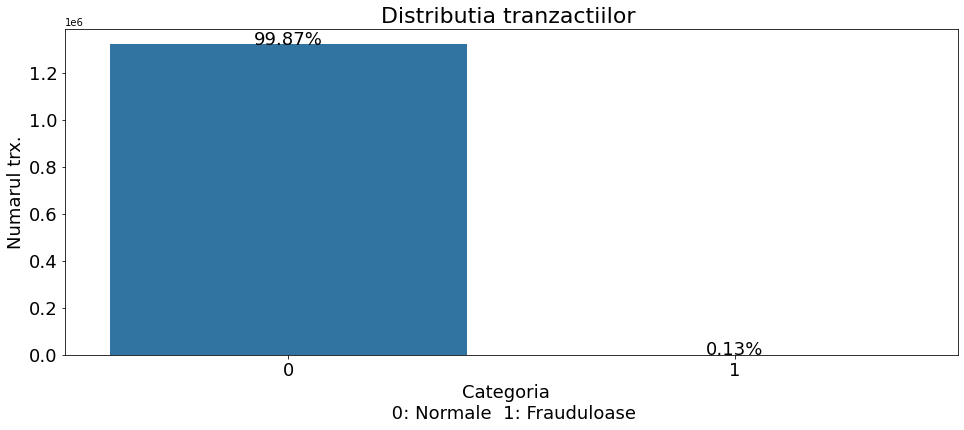

In [8]:
plt.figure(figsize=(16,6))
total = len(df)

g = sns.countplot(x='target', data=df, )
g.set_title("Distributia tranzactiilor ", fontsize=22)
g.set_xlabel("Categoria  \n 0: Normale  1: Frauduloase", fontsize=18)
g.set_ylabel('Numarul trx.', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 0.5,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=18) 


# Pastram variabilele importante

In [9]:
sample = df.drop(columns=['tx_id', 'sender_account_id', 'receiver_account_id',
                          'tx_type','f_time_true','alert_id','is_fraud', 'tx_behaviour_id'])

In [10]:
sample

,tx_amount,timestamp,sender_contaminat_f,receiver_contaminat_mtrx,target,cumulative_sar,init_balance
0,161.86,0,0,0,0,0,161.86
1,13.52,191,1,1,1,1,503.56
2,18.61,188,1,1,1,2,127.28
3,3.46,173,1,0,1,1,328.17
4,3.43,179,1,1,1,2,260.05
...,...,...,...,...,...,...,...
1323229,317.64,67,1,0,0,3,317.65
1323230,317.64,119,1,0,0,4,317.65
1323231,317.64,119,1,1,0,4,317.65
1323232,317.64,157,1,0,0,4,317.65


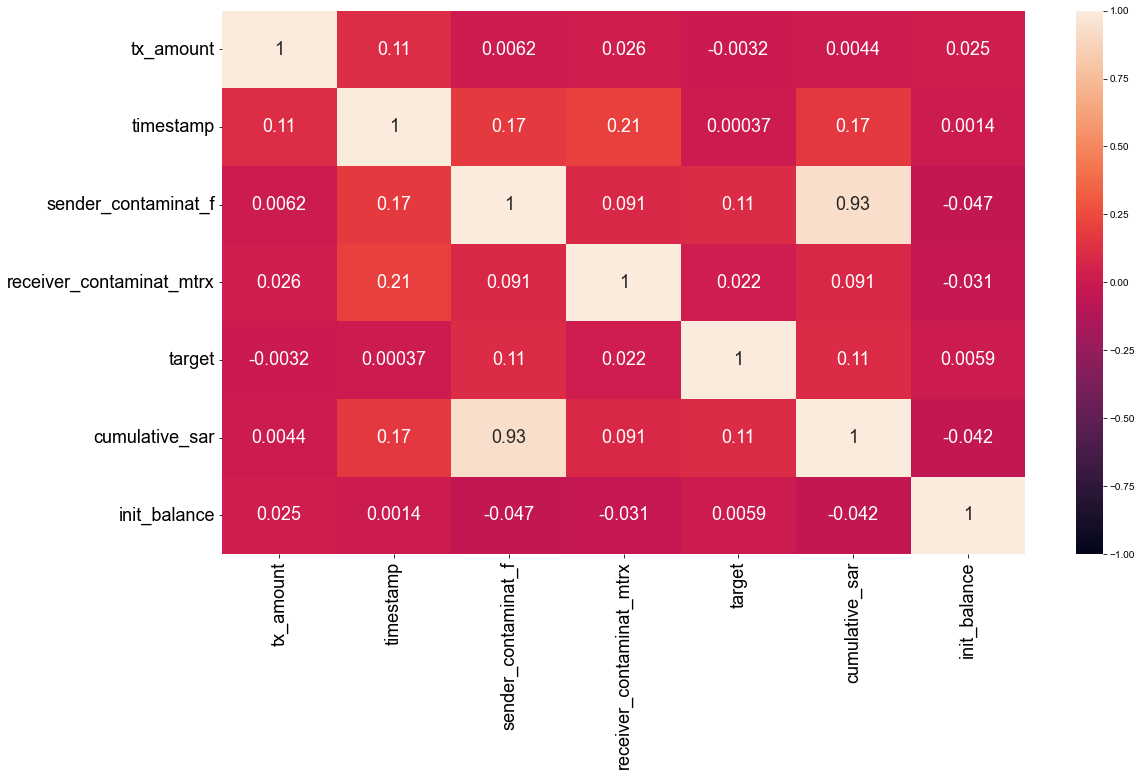

In [11]:
plt.figure(figsize=[18, 10])
#plt.title("Matricea de corelatie", fontsize=22)
sns.heatmap(sample.corr(), annot=True, vmax=1, vmin=-1, annot_kws={'size': 18})
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
sns.set(font_scale=1.5)
plt.show()
#Metoda de corelare:
#pearson : standard correlation coefficient

In [12]:
sample['tx_amount'] = sample['tx_amount'].astype(int)
print("Transaction Amounts Quantiles:")
print(sample['tx_amount'] .quantile([.01, .025, .1, .25, .5, .75, .9, .975, .99]))

Transaction Amounts Quantiles:
0.010          5.000
0.025          6.000
0.100         10.000
0.250         23.000
0.500        156.000
0.750        440.000
0.900        547.000
0.975      14644.175
0.990    1854724.070
Name: tx_amount, dtype: float64


In [13]:
print(pd.concat([sample[sample['target'] == 1]['tx_amount']\
                 .quantile([.01, .1, .25, .5, .75, .9, .99])\
                 .reset_index(), 
                 sample[sample['target'] == 0]['tx_amount']\
                 .quantile([.01, .1, .25, .5, .75, .9, .99])\
                 .reset_index()],
                axis=1, keys=['Fraud', "No Fraud"]))

  Fraud           No Fraud            
  index tx_amount    index   tx_amount
0  0.01       2.0     0.01        5.00
1  0.10       3.0     0.10       11.00
2  0.25       3.0     0.25       24.00
3  0.50      10.0     0.50      156.00
4  0.75      15.0     0.75      440.00
5  0.90      17.0     0.90      547.00
6  0.99      19.0     0.99  1862937.76


In [14]:
sample = df.drop(columns=['tx_id', 'sender_account_id', 'receiver_account_id','tx_type','f_time_true',
                          'alert_id','is_fraud','cumulative_sar'])
#'tx_amount','timestamp'

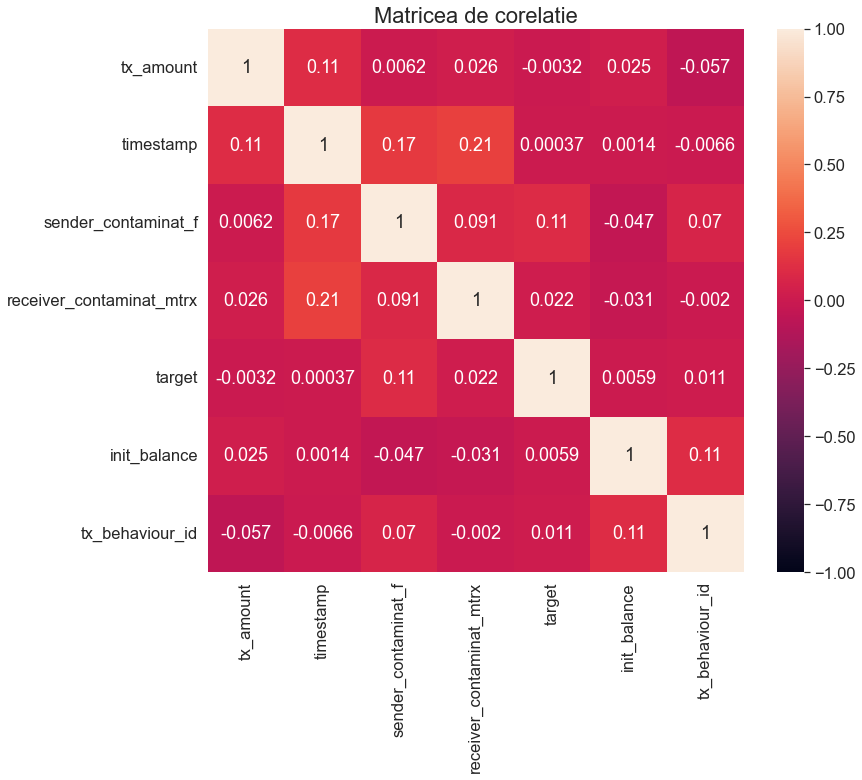

In [15]:
plt.figure(figsize=[12, 10])
plt.title("Matricea de corelatie", fontsize=22)
sns.heatmap(sample.corr(), annot=True, vmax=1, vmin=-1)
plt.show()
#Metoda de corelare:
#pearson : standard correlation coefficient

<AxesSubplot:>

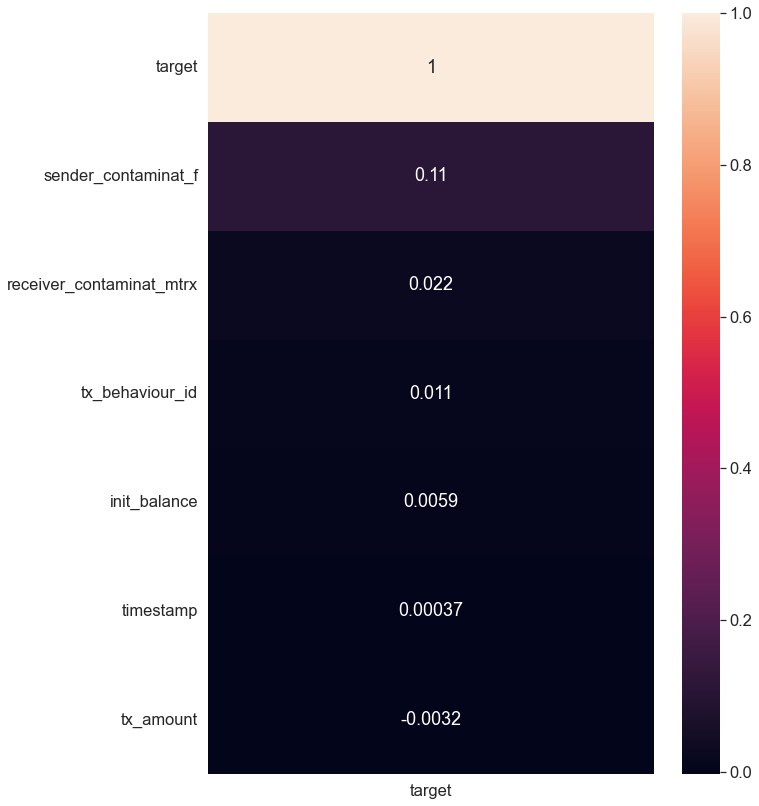

In [16]:
fig, ax = plt.subplots(figsize=(10,14))
target_corr = sample.corr()[['target']].sort_values( by='target', ascending=False)
sns.heatmap(target_corr, annot=True, ax=ax) 

# ------------------------- Construirea modelelor----------------------------

Definim variabila independenta news_type si variabila dependenta title

In [17]:
X=sample.drop('target', axis=1)
y=sample['target']

antrenam modelele fara undersampling sau oversampling

Impartim sample-ul in train si test

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [19]:
y_test.value_counts()

0    396465
1       506
Name: target, dtype: int64

Definim modelelor

In [20]:
clasificator_LR = LogisticRegression()
clasificator_DT = DecisionTreeClassifier()
clasificator_RF = RandomForestClassifier()
clasificator_NB = MultinomialNB()
clasificator_PA = PassiveAggressiveClassifier()
clasificator_XGB = xgb.XGBClassifier()
clasificator_GB= GradientBoostingClassifier()
clasificator_AB=  AdaBoostClassifier() 

# Oversampling

In [21]:
X=pd.concat([X_train,y_train],axis=1)

In [22]:
not_fraud=X[X.target==0]
fraud=X[X.target==1]

In [23]:
# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results
                      

In [24]:
# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

In [25]:
y_trainO=upsampled['target']
X_trainO=upsampled.drop('target', axis=1)

In [26]:
y_trainO.value_counts()

0    925050
1    925050
Name: target, dtype: int64

In [27]:
y_test.value_counts()

0    396465
1       506
Name: target, dtype: int64

In [28]:
clasificator_LR.fit(X_trainO, y_trainO)
clasificator_DT.fit(X_trainO, y_trainO)
clasificator_RF.fit(X_trainO, y_trainO)
clasificator_NB.fit(X_trainO, y_trainO)
clasificator_PA.fit(X_trainO, y_trainO)
clasificator_XGB.fit(X_trainO, y_trainO)
clasificator_GB.fit(X_trainO, y_trainO)
clasificator_AB.fit(X_trainO, y_trainO)

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



AdaBoostClassifier()

In [29]:
LR_predTrain = clasificator_LR.predict(X_trainO)
DT_predTrain = clasificator_DT.predict(X_trainO)
RF_predTrain = clasificator_RF.predict(X_trainO)
NB_predTrain = clasificator_NB.predict(X_trainO)
PA_predTrain = clasificator_PA.predict(X_trainO)
XGB_predTrain = clasificator_XGB.predict(X_trainO)
GB_predTrain= clasificator_GB.predict(X_trainO)
AB_predTrain= clasificator_AB.predict(X_trainO)

# Performanta modelelor pe baza de antrenare (balance)

In [30]:
print("Indicatori de performață pe train Regresie Logistica")
print(classification_report( y_trainO, LR_predTrain))
print("\n")

print("Indicatori de performață pe train Naive Bayes")
print(classification_report (y_trainO, NB_predTrain))
print("\n")

print("Indicatori de performață pe train Passivve Agressive")
print(classification_report( y_trainO, PA_predTrain))
print("\n")

print("Indicatori de performață pe train Decision Tree")
print(classification_report( y_trainO, DT_predTrain))
print("\n")

print("Indicatori de performață pe train Random Forest")
print(classification_report( y_trainO, RF_predTrain))
print("\n")

print("Indicatori de performață pe train  Ada Boost Classifier")
print(classification_report( y_trainO, AB_predTrain))
print("\n")

print("Indicatori de performață pe train Gradient Boosting")
print(classification_report( y_trainO, GB_predTrain))
print("\n")

print("Indicatori de performață pe train Extrem Gradient Boosting")
print(classification_report( y_trainO, XGB_predTrain))
print("\n")

Indicatori de performață pe train Regresie Logistica
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    925050
           1       0.98      1.00      0.99    925050

    accuracy                           0.99   1850100
   macro avg       0.99      0.99      0.99   1850100
weighted avg       0.99      0.99      0.99   1850100



Indicatori de performață pe train Naive Bayes
              precision    recall  f1-score   support

           0       1.00      0.03      0.06    925050
           1       0.51      1.00      0.67    925050

    accuracy                           0.51   1850100
   macro avg       0.75      0.51      0.37   1850100
weighted avg       0.75      0.51      0.37   1850100



Indicatori de performață pe train Passivve Agressive
              precision    recall  f1-score   support

           0       0.94      0.99      0.96    925050
           1       0.99      0.93      0.96    925050

    accuracy              

In [31]:
print (log_loss(y_trainO, LR_predTrain) )
print (log_loss(y_trainO, NB_predTrain) )
print (log_loss(y_trainO, PA_predTrain) )
print (log_loss(y_trainO, DT_predTrain) ) # bun
print (log_loss(y_trainO, RF_predTrain) ) # bun
print (log_loss(y_trainO, AB_predTrain) )
print (log_loss(y_trainO, GB_predTrain) )
print (log_loss(y_trainO, XGB_predTrain) ) # bun

0.40078645311383443
16.759245979705092
1.2870161295057152
9.99200722162641e-16
9.99200722162641e-16
0.16046032952498288
0.18295651301277852
9.99200722162641e-16


In [32]:
print (roc_auc_score(y_trainO, LR_predTrain) )
print (roc_auc_score(y_trainO, NB_predTrain) )
print (roc_auc_score(y_trainO, PA_predTrain) )
print (roc_auc_score(y_trainO, DT_predTrain) )
print (roc_auc_score(y_trainO, RF_predTrain) ) 
print (roc_auc_score(y_trainO, AB_predTrain) )
print (roc_auc_score(y_trainO, GB_predTrain) )
print (roc_auc_score(y_trainO, XGB_predTrain) )

0.9883963029025459
0.5147813631695584
0.9627371493432788
1.0
1.0
0.9953543051726933
0.9947029890276201
1.0


In [33]:
LR_pred = clasificator_LR.predict(X_test)
DT_pred = clasificator_DT.predict(X_test)
RF_pred = clasificator_RF.predict(X_test)
NB_pred = clasificator_NB.predict(X_test)
PA_pred = clasificator_PA.predict(X_test)
XGB_pred = clasificator_XGB.predict(X_test)
GB_pred = clasificator_GB.predict(X_test)
AB_pred = clasificator_AB.predict(X_test)

# Performata modelelor pe baza de test (unbalance) + confusion metrix

In [34]:
print("Indicatori de performață Regresie Logistica")
print(classification_report(y_test, LR_pred))
print("\n")
print("Indicatori de performață Naive Bayes")
print(classification_report(y_test, NB_pred))
print("\n")

print("Indicatori de performață Passivve Agressive")
print(classification_report(y_test, PA_pred))
print("\n")


print("Indicatori de performață Decision Tree")
print(classification_report(y_test, DT_pred))
print("\n")

print("Indicatori de performață Random Forest")
print(classification_report(y_test, RF_pred))
print("\n")


print("Indicatori de performață Ada Boost Classifier")
print(classification_report(y_test, AB_pred))
print("\n")

print("Indicatori de performață Gradient Boosting")
print(classification_report(y_test, GB_pred))
print("\n")

print("Indicatori de performață Extrem Gradient Boosting")
print(classification_report(y_test, XGB_pred))
print("\n")

Indicatori de performață Regresie Logistica
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    396465
           1       0.05      1.00      0.10       506

    accuracy                           0.98    396971
   macro avg       0.53      0.99      0.54    396971
weighted avg       1.00      0.98      0.99    396971



Indicatori de performață Naive Bayes
              precision    recall  f1-score   support

           0       1.00      0.03      0.06    396465
           1       0.00      1.00      0.00       506

    accuracy                           0.03    396971
   macro avg       0.50      0.51      0.03    396971
weighted avg       1.00      0.03      0.06    396971



Indicatori de performață Passivve Agressive
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    396465
           1       0.14      0.95      0.25       506

    accuracy                           0.99    396971

In [35]:
print (log_loss(y_test, LR_pred) )
print (log_loss(y_test, NB_pred) )
print (log_loss(y_test, PA_pred) )
print (log_loss(y_test, DT_pred) ) # bun
print (log_loss(y_test, RF_pred) ) # bun
print (log_loss(y_test, AB_pred) )
print (log_loss(y_test, GB_pred) )
print (log_loss(y_test, XGB_pred) ) # bun

0.7893348214416591
33.471207135144866
0.2508434580752267
0.0033932299301379027
0.0033932259016449893
0.32375604431635036
0.36960916242109476
0.0012180810928988418


In [36]:
print (roc_auc_score(y_test, LR_pred) )
print (roc_auc_score(y_test, NB_pred) )
print (roc_auc_score(y_test, PA_pred) )
print (roc_auc_score(y_test, DT_pred) ) # bun
print (roc_auc_score(y_test, RF_pred) ) # bun
print (roc_auc_score(y_test, AB_pred) )
print (roc_auc_score(y_test, GB_pred) )
print (roc_auc_score(y_test, XGB_pred) ) # bun

0.9885588891831562
0.5148474644672292
0.97267897036104
0.9634362128871211
0.9614624505928854
0.9933335157757073
0.9946426544587795
0.9861660079051384


<AxesSubplot:title={'center':'XGBoost'}>

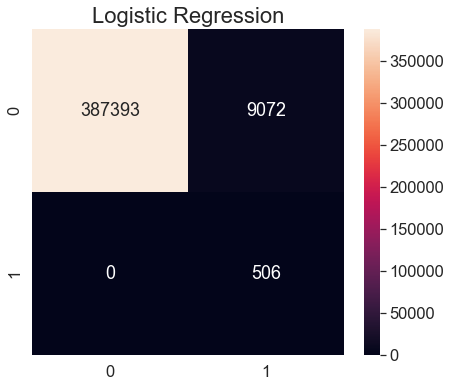

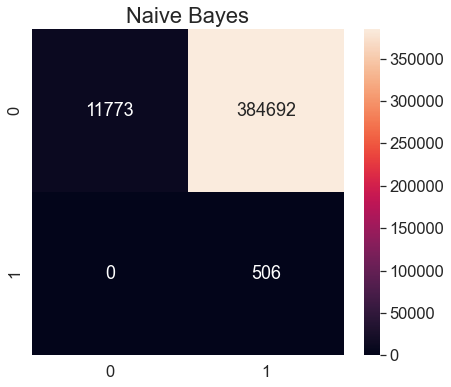

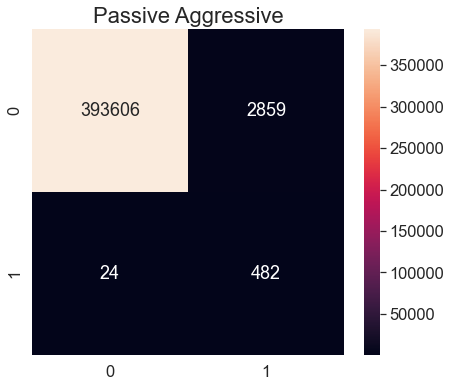

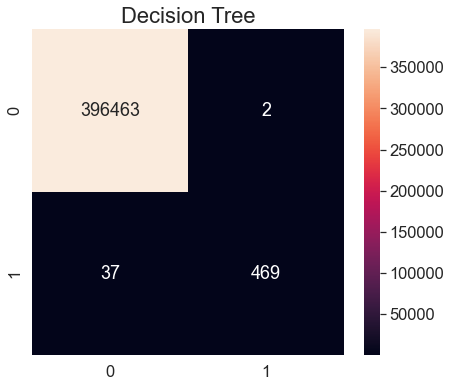

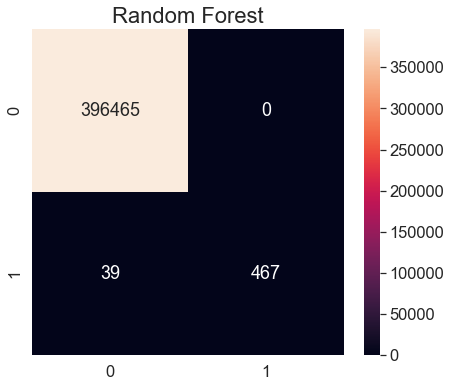

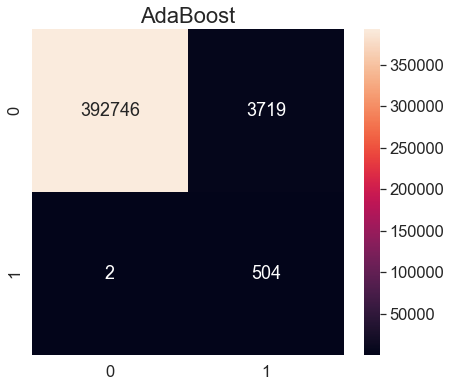

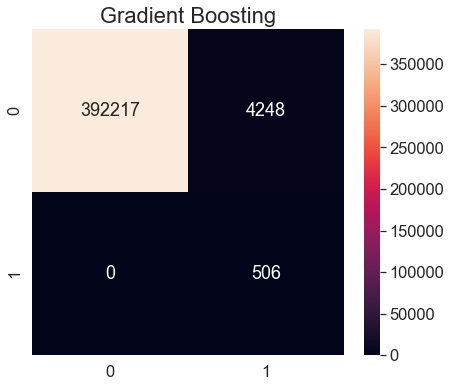

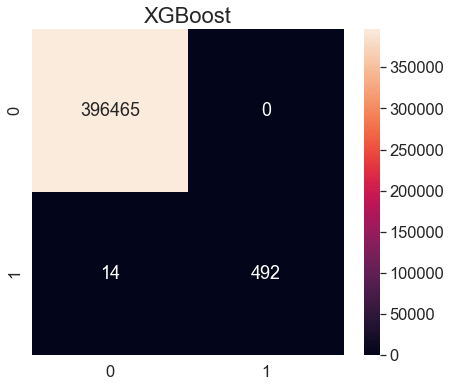

In [37]:

cmDT = confusion_matrix(y_test, LR_pred)
plt.figure(figsize = (7, 6))
plt.title("Logistic Regression", fontsize=22)
sns.heatmap(cmDT, annot = True,fmt=".0f")

cmDT = confusion_matrix(y_test, NB_pred)
plt.figure(figsize = (7, 6))
plt.title("Naive Bayes", fontsize=22)
sns.heatmap(cmDT, annot = True,fmt=".0f")

cmDT = confusion_matrix(y_test, PA_pred)
plt.figure(figsize = (7, 6))
plt.title("Passive Aggressive", fontsize=22)
sns.heatmap(cmDT, annot = True,fmt=".0f")

cmDT = confusion_matrix(y_test, DT_pred)
plt.figure(figsize = (7, 6))
plt.title("Decision Tree", fontsize=22)
sns.heatmap(cmDT, annot = True,fmt=".0f")


cmDT = confusion_matrix(y_test, RF_pred)
plt.figure(figsize = (7, 6))
plt.title("Random Forest", fontsize=22)
sns.heatmap(cmDT, annot = True,fmt=".0f")

cmDT = confusion_matrix(y_test, AB_pred)
plt.figure(figsize = (7, 6))
plt.title("AdaBoost", fontsize=22)
sns.heatmap(cmDT, annot = True,fmt=".0f")

cmDT = confusion_matrix(y_test, GB_pred)
plt.figure(figsize = (7, 6))
plt.title("Gradient Boosting", fontsize=22)
sns.heatmap(cmDT, annot = True,fmt=".0f")

cmDT = confusion_matrix(y_test, XGB_pred)
plt.figure(figsize = (7, 6))
plt.title("XGBoost", fontsize=22)
sns.heatmap(cmDT, annot = True,fmt=".0f")

# Undersampling

In [38]:
Uclasificator_LR = LogisticRegression()
Uclasificator_DT = DecisionTreeClassifier()
Uclasificator_RF = RandomForestClassifier()
Uclasificator_NB = MultinomialNB()
Uclasificator_PA = PassiveAggressiveClassifier()
Uclasificator_XGB = xgb.XGBClassifier()
Uclasificator_GB= GradientBoostingClassifier()
Uclasificator_AB=  AdaBoostClassifier() 

In [39]:
not_fraud_downsampled = resample(not_fraud,
                                replace = False, # sample without replacement
                                n_samples = len(fraud), # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_fraud_downsampled, fraud])

# checking counts
downsampled.target.value_counts()

0    1213
1    1213
Name: target, dtype: int64

In [40]:
y_trainU=downsampled['target']
X_trainU=downsampled.drop('target', axis=1)

In [41]:
Uclasificator_LR.fit(X_trainU, y_trainU)
Uclasificator_DT.fit(X_trainU, y_trainU)
Uclasificator_RF.fit(X_trainU, y_trainU)
Uclasificator_NB.fit(X_trainU, y_trainU)
Uclasificator_PA.fit(X_trainU, y_trainU)
Uclasificator_XGB.fit(X_trainU, y_trainU)
Uclasificator_GB.fit(X_trainU, y_trainU)
Uclasificator_AB.fit(X_trainU, y_trainU)

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



AdaBoostClassifier()

In [42]:
LR_predT = Uclasificator_LR.predict(X_trainU)
DT_predT = Uclasificator_DT.predict(X_trainU)
RF_predT = Uclasificator_RF.predict(X_trainU)
NB_predT = Uclasificator_NB.predict(X_trainU)
PA_predT = Uclasificator_PA.predict(X_trainU)
XGB_predT = Uclasificator_XGB.predict(X_trainU)
GB_predT = Uclasificator_GB.predict(X_trainU)
AB_predT = Uclasificator_AB.predict(X_trainU)

In [43]:
print("Indicatori de performață Regresie Logistica")
print(classification_report(y_trainU, LR_predT))
print("\n")

print("Indicatori de performață Naive Bayes")
print(classification_report(y_trainU, NB_predT))
print("\n")

print("Indicatori de performață Passivve Agressive")
print(classification_report(y_trainU, PA_predT))
print("\n")


print("Indicatori de performață Decision Tree")
print(classification_report(y_trainU, DT_predT))
print("\n")

print("Indicatori de performață Random Forest")
print(classification_report(y_trainU, RF_predT))
print("\n")

print("Indicatori de performață Ada Boost Classifier")
print(classification_report(y_trainU, AB_predT))
print("\n")


print("Indicatori de performață Gradient Boosting")
print(classification_report(y_trainU, GB_predT))
print("\n")



print("Indicatori de performață Extrem Gradient Boosting")
print(classification_report(y_trainU, XGB_predT))
print("\n")

Indicatori de performață Regresie Logistica
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      1213
           1       0.97      1.00      0.99      1213

    accuracy                           0.99      2426
   macro avg       0.99      0.99      0.99      2426
weighted avg       0.99      0.99      0.99      2426



Indicatori de performață Naive Bayes
              precision    recall  f1-score   support

           0       1.00      0.03      0.06      1213
           1       0.51      1.00      0.67      1213

    accuracy                           0.51      2426
   macro avg       0.75      0.51      0.36      2426
weighted avg       0.75      0.51      0.36      2426



Indicatori de performață Passivve Agressive
              precision    recall  f1-score   support

           0       0.97      0.84      0.90      1213
           1       0.86      0.98      0.91      1213

    accuracy                           0.91      2426

In [44]:

print (log_loss(y_trainU, LR_predT) )
print (log_loss(y_trainU, NB_predT) )
print (log_loss(y_trainU, PA_predT) )
print (log_loss(y_trainU, DT_predT) ) # bun
print (log_loss(y_trainU, RF_predT) ) # bun
print (log_loss(y_trainU, AB_predT) )
print (log_loss(y_trainU, GB_predT) )
print (log_loss(y_trainU, XGB_predT) ) # bun

0.46982902232061863
16.771484138078133
3.189135792726193
9.992007221626415e-16
9.992007221626415e-16
9.992007221626415e-16
0.04271175926505566
9.992007221626415e-16


In [45]:
LR_predU = Uclasificator_LR.predict(X_test)
DT_predU = Uclasificator_DT.predict(X_test)
RF_predU = Uclasificator_RF.predict(X_test)
NB_predU = Uclasificator_NB.predict(X_test)
PA_predU = Uclasificator_PA.predict(X_test)
XGB_predU = Uclasificator_XGB.predict(X_test)
GB_predU = Uclasificator_GB.predict(X_test)
AB_predU = Uclasificator_AB.predict(X_test)

In [46]:
print("Indicatori de performață Regresie Logistica")
print(classification_report(y_test, LR_predU))
print("\n")

print("Indicatori de performață Naive Bayes")
print(classification_report(y_test, NB_predU))
print("\n")

print("Indicatori de performață Passivve Agressive")
print(classification_report(y_test, PA_predU))
print("\n")

print("Indicatori de performață Decision Tree")
print(classification_report(y_test, DT_predU))
print("\n")

print("Indicatori de performață Random Forest")
print(classification_report(y_test, RF_predU))
print("\n")

print("Indicatori de performață Ada Boost Classifier")
print(classification_report(y_test, AB_predU))
print("\n")


print("Indicatori de performață Gradient Boosting")
print(classification_report(y_test, GB_predU))
print("\n")


print("Indicatori de performață Extrem Gradient Boosting")
print(classification_report(y_test, XGB_predU))
print("\n")

Indicatori de performață Regresie Logistica
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    396465
           1       0.05      1.00      0.10       506

    accuracy                           0.98    396971
   macro avg       0.53      0.99      0.54    396971
weighted avg       1.00      0.98      0.99    396971



Indicatori de performață Naive Bayes
              precision    recall  f1-score   support

           0       1.00      0.03      0.06    396465
           1       0.00      1.00      0.00       506

    accuracy                           0.03    396971
   macro avg       0.50      0.51      0.03    396971
weighted avg       1.00      0.03      0.06    396971



Indicatori de performață Passivve Agressive
              precision    recall  f1-score   support

           0       1.00      0.84      0.91    396465
           1       0.01      0.98      0.02       506

    accuracy                           0.84    396971

In [47]:


print (log_loss(y_test, LR_predU) )
print (log_loss(y_test, NB_predU) )
print (log_loss(y_test, PA_predU) )
print (log_loss(y_test, DT_predU) ) # bun
print (log_loss(y_test, RF_predU) ) # bun
print (log_loss(y_test, AB_predU) )
print (log_loss(y_test, GB_predU) )
print (log_loss(y_test, XGB_predU) ) # bun

0.7853324623382292
33.47129414295146
5.408231220256272
0.3399394943290161
0.4613153885593514
0.3407225645883828
0.3772658473873229
0.37848395667967116


<AxesSubplot:title={'center':'XGBoost'}>

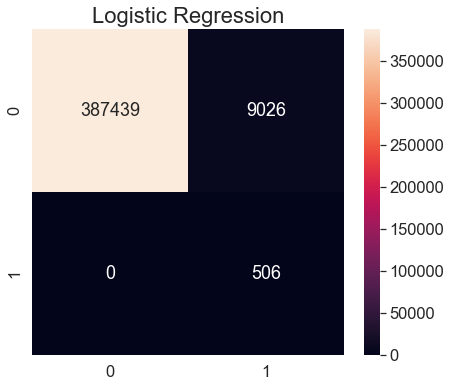

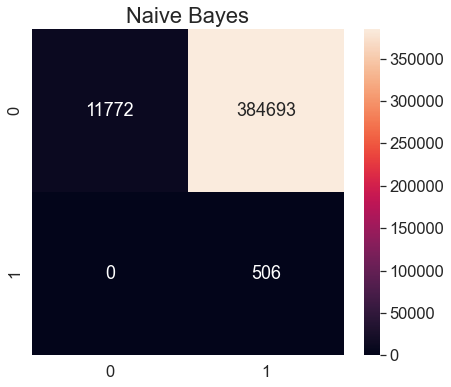

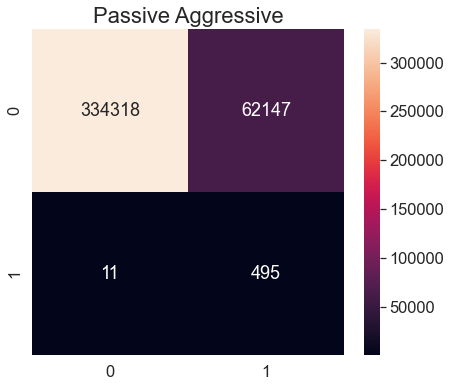

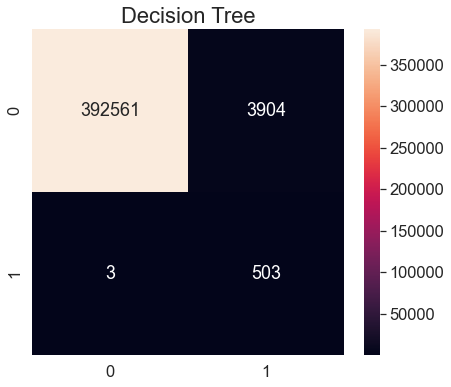

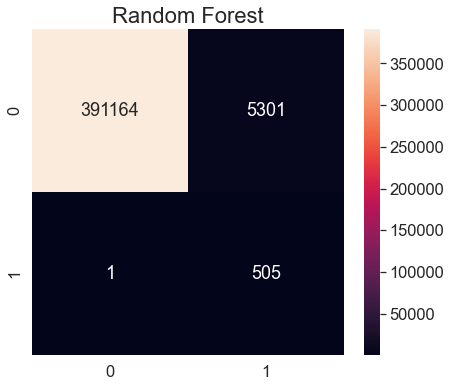

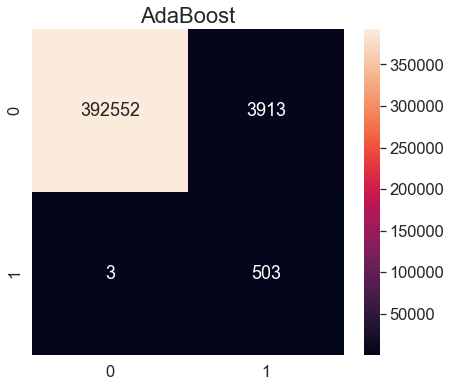

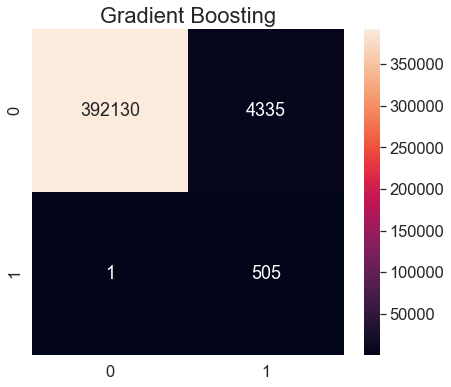

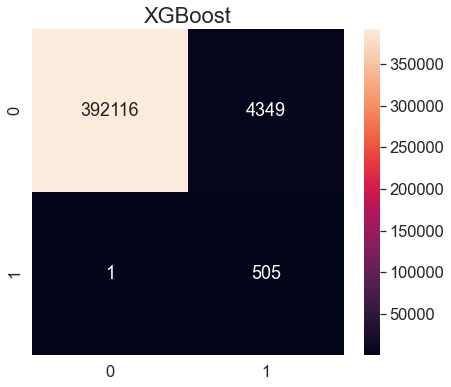

In [48]:
cmDT = confusion_matrix(y_test, LR_predU)
plt.figure(figsize = (7, 6))
plt.title("Logistic Regression", fontsize=22)
sns.heatmap(cmDT, annot = True,fmt=".0f")

cmDT = confusion_matrix(y_test, NB_predU)
plt.figure(figsize = (7, 6))
plt.title("Naive Bayes", fontsize=22)
sns.heatmap(cmDT, annot = True,fmt=".0f")

cmDT = confusion_matrix(y_test, PA_predU)
plt.figure(figsize = (7, 6))
plt.title("Passive Aggressive", fontsize=22)
sns.heatmap(cmDT, annot = True,fmt=".0f")

cmDT = confusion_matrix(y_test, DT_predU)
plt.figure(figsize = (7, 6))
plt.title("Decision Tree", fontsize=22)
sns.heatmap(cmDT, annot = True,fmt=".0f")


cmDT = confusion_matrix(y_test, RF_predU)
plt.figure(figsize = (7, 6))
plt.title("Random Forest", fontsize=22)
sns.heatmap(cmDT, annot = True,fmt=".0f")

cmDT = confusion_matrix(y_test, AB_predU)
plt.figure(figsize = (7, 6))
plt.title("AdaBoost", fontsize=22)
sns.heatmap(cmDT, annot = True,fmt=".0f")

cmDT = confusion_matrix(y_test, GB_predU)
plt.figure(figsize = (7, 6))
plt.title("Gradient Boosting", fontsize=22)
sns.heatmap(cmDT, annot = True,fmt=".0f")

cmDT = confusion_matrix(y_test, XGB_predU)
plt.figure(figsize = (7, 6))
plt.title("XGBoost", fontsize=22)
sns.heatmap(cmDT, annot = True,fmt=".0f")